In [2]:
## load packages
import os 
import pathlib
import pickle as pkl
import gdown

import sklearn
import seaborn as sns
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)

#### BILLS
RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include only bills from years where position data is available (IA: 2009-2022, MA: 2010-2021, NE: 2000-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2002-2022)
- Include bills with status avaiable and remove duplicate bills
- Subset and use columns: state, state_unified_bill_id, bill_year, pass, ncsl_topics, ncsl_metatopics

In [10]:
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] #states that only have lobby records
#position data for the above states are avaible during the following ranges: 
pos_spans = [range(2009, 2023), range(2009, 2023), range(2000, 2023), range(2014, 2023), range(2018, 2023), range(2002, 2023)]

In [11]:
#BILLS
bills = pd.read_parquet("../data/raw/chorus/bills.parquet") #load bills data
bills_lob = bills[bills["state"].isin(states_lobby)]        #subset states with lobby records
bills_lob = bills_lob[bills_lob["status"].notna()]          #remove rows with no status metadata
print(f"number of duplicated bills: {len(bills_lob[bills_lob["state_unified_bill_id"].duplicated()])}")
bills_lob.drop_duplicates(subset="state_unified_bill_id",   #remove rows with duplicate bill ids
                          ignore_index=True, inplace=True)
bills_lob["pass"] = bills_lob.index.map(bills_lob["status"].isin([4,5]).to_dict())#create new col with binary pass/fail status
bills_lob = bills_lob.replace(to_replace={"ncsl_metatopics":{None: list(["M"])},  #replace none with 'M' (so it can be made to list)
                                          "ncsl_topics":{None: list(["M"])}})
bills_lob["ncsl_topics"] = bills_lob["ncsl_topics"].str.split("; ")               #split topics into lists 
bills_lob["ncsl_metatopics"] = bills_lob["ncsl_metatopics"].str.split("; ")       #split topics into lists 
print(f"number of bills after removing duplicates: {len(bills_lob)}")
#get year from last_action_date
bills_lob["bill_year"] = bills_lob["last_action_date"].str.split(r"-", expand=True)[0]
#subset bills
bills_lob = bills_lob[["state_unified_bill_id", "pass",  "state", "ncsl_topics", "ncsl_metatopics", "bill_year"]]

number of duplicated bills: 1358
number of bills after removing duplicates: 195230


In [12]:
#fix bill_year col: inspect years: none, 0000, 1969
print(f"number of bills where year is None, 0000 or 1969: {len(bills_lob[bills_lob["bill_year"].isin([None, "0000", "1969"])])}")
#set bill_year to year-suffix from bill id in the 374 cases above
bills_lob.loc[bills_lob[bills_lob["bill_year"].isin([None, "0000", "1969"])].index, "bill_year"] = bills_lob[bills_lob["bill_year"].isin([None, "0000", "1969"])]["state_unified_bill_id"].str.split("_", expand=True)[3]
#set as type int 
bills_lob["bill_year"] = bills_lob["bill_year"].astype("int32")

number of bills where year is None, 0000 or 1969: 374


In [13]:
#subset so bills only come fra year ranges where there are poistions from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, pos_spans)):
    i_ind = bills_lob[(bills_lob["state"] == state) & (bills_lob["bill_year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind

bills_lob = bills_lob.iloc[keep_ind]
print(f"number of bills after removing ones outside position ranges: {len(bills_lob)}")
print(f"\nPercentage of bills passed and failed:\n{bills_lob["pass"].value_counts(normalize = True)}")
bills_lob

number of bills after removing ones outside position ranges: 160753

Percentage of bills passed and failed:
pass
False    0.878976
True     0.121024
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,bill_year
0,IA_H_0000000001_2013,False,IA,[M],[M],2013
1,IA_H_0000000002_2013,False,IA,[M],[M],2013
2,IA_H_0000000011_2013,False,IA,[M],[M],2013
3,IA_H_0000000101_2013,False,IA,[M],[M],2013
4,IA_H_0000002351_2013,False,IA,[M],[M],2014
...,...,...,...,...,...,...
195225,WI_AB_0000000006_2011-X2,False,WI,[M],[M],2011
195226,WI_AB_0000000007_2011-X2,False,WI,[M],[M],2011
195227,WI_AB_0000000008_2011-X2,False,WI,[M],[M],2011
195228,WI_AB_0000000009_2011-X2,False,WI,[M],[M],2011


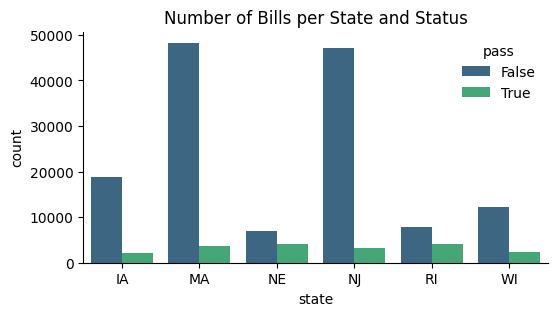

In [14]:
#plot outcomes(passed/failed) by state
figure, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(bills_lob, x = "state", hue = "pass",stat = "count", palette= "viridis")
sns.move_legend(p, "upper right", frameon = False)
ax.set_title('Number of Bills per State and Status')
sns.despine()
plt.savefig("../figs/bills_status.png")

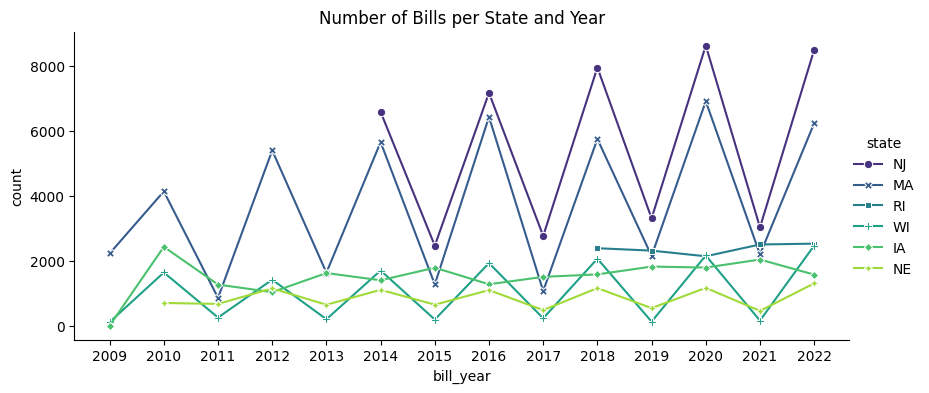

In [15]:
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = bills_lob.value_counts(["state", "bill_year"]).to_frame().reset_index(), 
                 x = "bill_year", y = "count", hue = "state", palette= "viridis", style="state",
                markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/bills_lineplot.png")

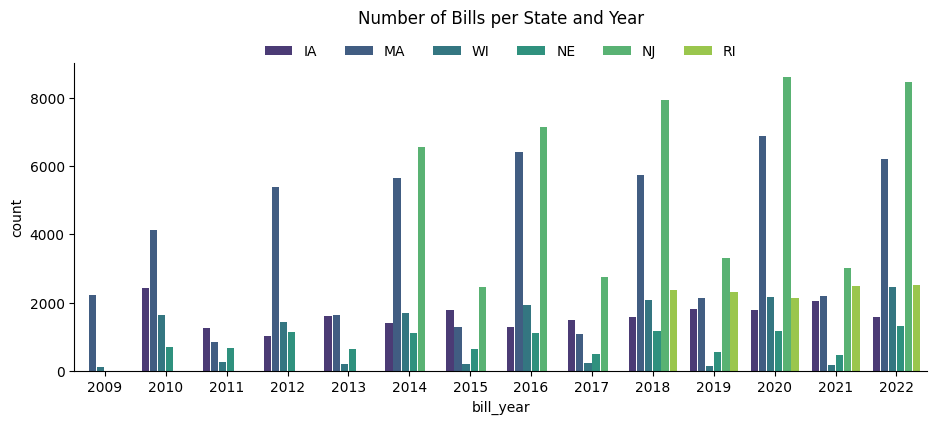

In [16]:
#bills per state per year
fig, ax = plt.subplots(figsize=(11, 4))
p = sns.countplot(bills_lob, x = "bill_year", hue = "state",stat = "count", palette= "viridis", 
                  gap=.1)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Bills per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/bills_barplot.png")

#### POSITIONS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include from years where bills also have been collected (IA: 2009-2022, MA: 2010-2021, NE: 2010-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2009-2022)
- All bills in POSITIONS should also be in BILLS (the ones that arent represented in bills were prevously removed due to having status = NA)
- Subset relevant columns (state_client_id, state_unified_bill_id, year, position_numeric)

In [17]:
#POSITIONS
bills_spans = [range(2009, 2024), range(2009, 2023), range(2010, 2023), range(2014, 2024), range(2018, 2024), range(2009, 2024)]

positions = pd.read_parquet("../data/raw/chorus/positions.parquet")#load positions
#subset so positions only come from year ranges where there are bills from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, bills_spans)):
    i_ind = positions[(positions["state"] == state) & (positions["year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind
positions_lob = positions.iloc[keep_ind]
positions_lob.head(3)

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
853664,None,Metro Waste Authority,Ned Chiodo,None,FOR,2010-04-13 07:41:00+00:00,NaT,2010,lobbying,83,None,None,IA,1.0,None,None,152002.0,IA_H_0000002512_2009,IA_0,None,None
853665,None,Metro Waste Authority,Larry Pope,None,FOR,2010-04-13 07:41:00+00:00,NaT,2010,lobbying,83,None,None,IA,1.0,None,None,152002.0,IA_H_0000002512_2009,IA_0,None,None
853666,None,Metro Waste Authority,Julie Smith,None,FOR,2010-04-13 07:41:00+00:00,NaT,2010,lobbying,83,None,None,IA,1.0,None,None,152002.0,IA_H_0000002512_2009,IA_0,None,None


In [18]:
#check that bills in positions is also in bills df
print(f"number of unique bill ids in positions data: {len(positions_lob["state_unified_bill_id"].unique())}")
print(f"number of unique bill ids in bills data: {len(bills_lob["state_unified_bill_id"].unique())}")
print(f"\nOf bills in positions data also represented in bills data:")
print(positions_lob["state_unified_bill_id"].drop_duplicates().isin(bills_lob["state_unified_bill_id"]).value_counts())

### bills present in positions data but not in bills, was taken out of bills bc status value wasnt avaiable
not_in_bills = positions_lob[~positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]["state_unified_bill_id"].unique()
print(bills[bills["state_unified_bill_id"].isin(not_in_bills)]["status"].isna().value_counts())
print("The bills not present in the bills dataset (3603) have status value NA (why they arent there)")
#remove the bills from positions not present in bills data
positions_lob = positions_lob[positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]


number of unique bill ids in positions data: 89350
number of unique bill ids in bills data: 160753

Of bills in positions data also represented in bills data:
state_unified_bill_id
True     85747
False     3603
Name: count, dtype: int64
status
True    3603
Name: count, dtype: int64
The bills not present in the bills dataset (3603) have status value NA (why they arent there)


In [19]:
#subset relevant columns 
positions_lob = positions_lob[["state_client_id", "state", "state_unified_bill_id", "position_numeric", "year"]] #keep relevant columns
positions_lob = positions_lob.replace(to_replace={"position_numeric": {-1.0: "oppose", 0.0: "neutral", 1.0: "support"}})
positions_lob.reset_index(drop=True, inplace=True)
positions_lob

,state_client_id,state,state_unified_bill_id,position_numeric,year
0,IA_0,IA,IA_H_0000002512_2009,support,2010
1,IA_0,IA,IA_H_0000002512_2009,support,2010
2,IA_0,IA,IA_H_0000002512_2009,support,2010
3,IA_1,IA,IA_H_0000002531_2009,neutral,2010
4,IA_2,IA,IA_H_0000002531_2009,neutral,2010
...,...,...,...,...,...
1559843,WI_1685,WI,WI_AB_0000000971_2021,oppose,2022
1559844,WI_1685,WI,WI_AB_0000000970_2021,oppose,2022
1559845,WI_1686,WI,WI_SB_0000000860_2021,support,2022
1559846,WI_1686,WI,WI_AB_0000000903_2021,support,2022


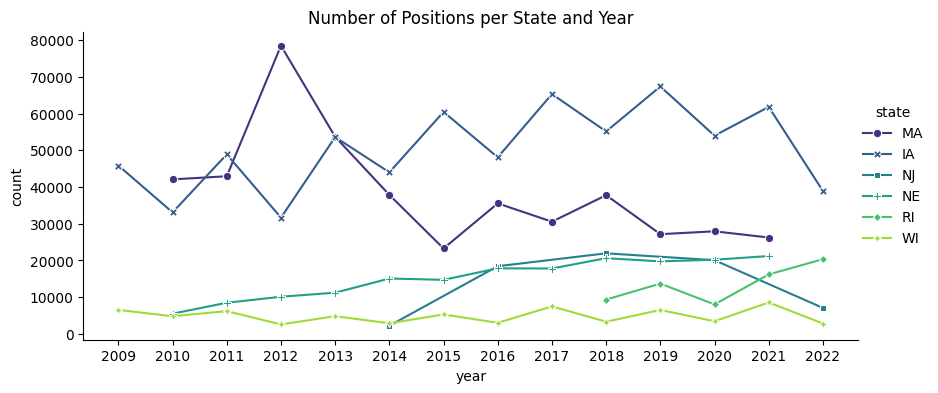

In [20]:
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = positions_lob.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= "viridis", style="state",
                markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.8),  frameon = False)
sns.despine()
ax.set_title('Number of Positions per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/positions_lineplot.png")

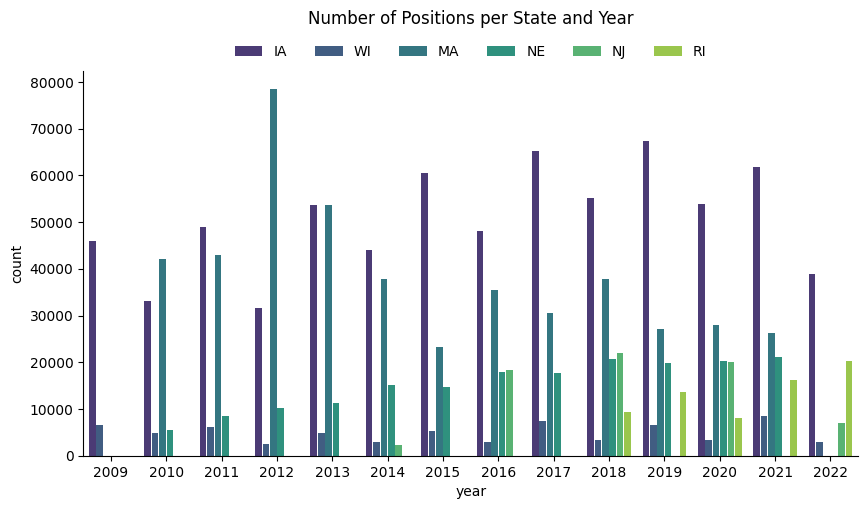

In [21]:
#positions per state per year
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.countplot(positions_lob, x = "year", hue = "state",stat = "count", palette= "viridis", 
                  gap=.1)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Positions per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/positions_barplot.png")

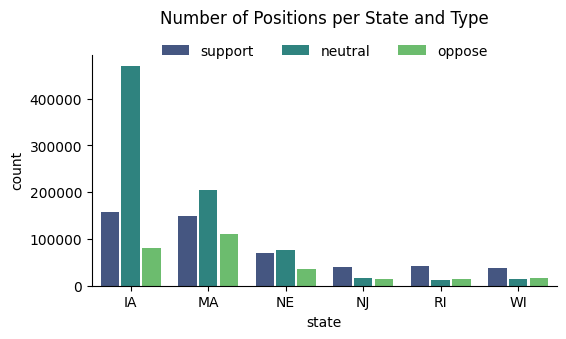

In [22]:
figure, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(positions_lob, x = "state", hue = "position_numeric",stat = "count", 
                  palette= "viridis", gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3,  frameon = False, title=None)
ax.set_title('Number of Positions per State and Type', y=1.1)
sns.despine()
plt.savefig("../figs/position_type.png")

In [23]:
print(positions_lob.head(3))

  state_client_id state state_unified_bill_id position_numeric  year
0            IA_0    IA  IA_H_0000002512_2009          support  2010
1            IA_0    IA  IA_H_0000002512_2009          support  2010
2            IA_0    IA  IA_H_0000002512_2009          support  2010


In [24]:
print(bills_lob.head(3))

  state_unified_bill_id   pass state ncsl_topics ncsl_metatopics  bill_year
0  IA_H_0000000001_2013  False    IA         [M]             [M]       2013
1  IA_H_0000000002_2013  False    IA         [M]             [M]       2013
2  IA_H_0000000011_2013  False    IA         [M]             [M]       2013


#### BLOCKS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- rename enity id to state client id 
- subset only rows with clients (not bills)          
- merge with positions: (orgs only in blocks are dropped )

In [25]:
blocks = pd.read_parquet("../data/raw/chorus/block_assignments.parquet")#load positions
blocks = blocks.rename(columns={"entity_id": "state_client_id"})        #rename to state_client_id 
blocks = blocks[blocks["state"].isin(states_lobby)]                     #only states with lobby recs
blocks = blocks[blocks["state_client_id"].str.match(r"[A-Z][A-Z]_\d+")] #keep only rows with clients
print(f"Number of client ids in blocks: {len(blocks)}\nnumber of clients per {blocks["state"].value_counts()}")
blocks["block_1"] = blocks["block_1"].astype(str) #change block_1 type to str
blocks.head(4)

Number of client ids in blocks: 4312
number of clients per state
MA    1058
IA    1048
WI     785
NE     726
NJ     613
RI      82
Name: count, dtype: int64


,state_client_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
0,MA_1,3283,150,0,12,3.0,3.0,2.0,MA,lobbying
1,MA_10,4139,20,27,26,0.0,3.0,2.0,MA,lobbying
2,MA_100,3291,209,42,6,0.0,3.0,2.0,MA,lobbying
3,MA_1000,1311,128,62,26,0.0,3.0,2.0,MA,lobbying


In [26]:
positions_blocks = positions_lob.merge(blocks, how="left", on=["state_client_id", "state"], indicator=True)
print(f"number of client ids not in blocks: {len(positions_blocks.loc[positions_blocks["_merge"] == "left_only", "state_client_id"].unique())}")
#remove rows where no blocks have been assigned 
positions_blocks = positions_blocks[positions_blocks["_merge"] == "both"]
print(f"number of positions in total after cleaning: {len(positions_blocks)}")

number of client ids not in blocks: 7886
number of positions in total after cleaning: 1454787


FORMAT POSITIONS_BLOCKS TO 1 ROW PER BILL (new df : PB)

In [27]:
pb = positions_blocks[["state_unified_bill_id", "state_client_id", "position_numeric", "block_1"]].sort_values("state_unified_bill_id").reset_index(drop=True)

In [28]:
#count df: bill id, position, block, count
pb_counts = pd.DataFrame(pb.value_counts(["state_unified_bill_id", "position_numeric", "block_1"], sort = False)).reset_index()
print(pb_counts.head(1))
#pos list df: pivot df to get only one row per bill
pb_pos_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["block_1"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="block_1").reset_index().replace({None: list(["N"])})
#rename position headers 
pb_pos_list.rename(columns={"neutral":"neut_blocks", "oppose":"opp_blocks", "support":"sup_blocks"}, inplace=True)
print(pb_pos_list.head(1))
#count list: pivot to get counts (1 per bill)
pb_count_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["count"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="count").reset_index().replace({None: list([0])})
pb_count_list.rename(columns={"neutral":"neut_counts", "oppose":"opp_counts", "support":"sup_counts"}, inplace=True)
print(pb_count_list.head(1))

    state_unified_bill_id position_numeric block_1  count
0  IA_HCR_0000000003_2009          neutral     146      1
position_numeric   state_unified_bill_id neut_blocks opp_blocks sup_blocks
0                 IA_HCR_0000000003_2009       [146]          N          N
position_numeric   state_unified_bill_id neut_counts opp_counts sup_counts
0                 IA_HCR_0000000003_2009         [1]          0          0


In [29]:
##merge on bill_id
pb_list = pb_pos_list.merge(pb_count_list, on="state_unified_bill_id", how="left")

In [30]:
#MERGE BILLS AND POSITIONS DATA (PB_LIST)
features = bills_lob.merge(pb_list, on="state_unified_bill_id", how="left", indicator=True)

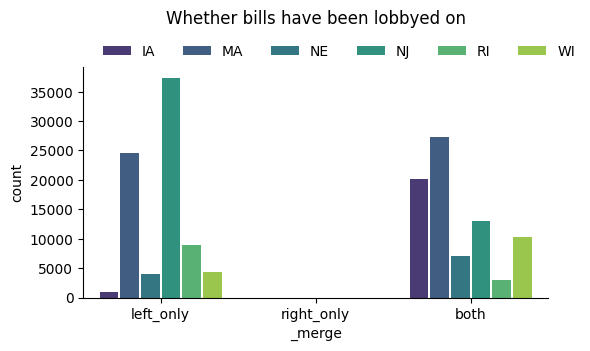

In [31]:
figure, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(features, x = "_merge", hue = "state",stat = "count", 
                  palette= "viridis", gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.55, 1.15), ncol=6,  frameon = False, title=None)
ax.set_title('Whether bills have been lobbyed on', y=1.15)
sns.despine()
#plt.savefig("../figs/position_type.png")

In [32]:
#FIX NANS 
features["neut_blocks"].replace({None: list(["N"])}, inplace=True)
features["opp_blocks"].replace({None: list(["N"])}, inplace=True)
features["sup_blocks"].replace({None: list(["N"])}, inplace=True)
features["neut_counts"].replace({None: list([0])}, inplace=True)
features["opp_counts"].replace({None: list([0])}, inplace=True)
features["sup_counts"].replace({None: list([0])}, inplace=True)

/tmp/ipykernel_496/3829060151.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["neut_blocks"].replace({None: list(["N"])}, inplace=True)
/tmp/ipykernel_496/3829060151.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [42]:
features.loc[160749 , "neut_blocks"]

'N'

In [ ]:
###save selected features to parquet 
with open("../data/preprocessed/features.pkl", 'wb') as file:
    pkl.dump(features, file)


### FEATURE TRANSFORMATIONS

- PASS: outcome - remove from remaining data !
- STATE: one hot encoding
- TOPICS: multi-var encoding
- METATOPICS: multi-var encoding
- YEAR: ordinal encoding
- BLOCKS: multi-var encoding
- COUNTS: multi-var enc structure; but keeping values and log transforming

In [3]:
#get saved features 
with open('../data/preprocessed/features.pkl', 'rb') as file:
    features = pkl.load(file)

n_samples = len(features)               #save length of data to check when transforming each feature
print(f"number of samples: {n_samples}")
#change pass from false/true to failed/passed
features["pass"] = np.where(features['pass'] == True, 'passed', 'failed')
#change _merge values to indication of lobby or no lobby activty
features["_merge"] = np.where(features['_merge'] == "both", 'lobby', 'no_lobby')
features = features.rename(columns={"_merge": "lobbied"})
print(f"distribution of bills with position data and no position data:\n{features["lobbied"].value_counts(normalize=True)}")
features.head(5)

number of samples: 160753
distribution of bills with position data and no position data:
lobbied
lobby       0.501552
no_lobby    0.498448
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,bill_year,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,lobbied
0,IA_H_0000000001_2013,failed,IA,[M],[M],2013,"[107, 116, 196, 262, 5, 51, 70, 86]","[107, 115, 191, 62, 90]","[32, 70]","[4, 2, 12, 4, 9, 11, 1, 6]","[4, 2, 2, 4, 1]","[1, 4]",lobby
1,IA_H_0000000002_2013,failed,IA,[M],[M],2013,"[107, 119, 12, 161, 19, 196, 203, 23, 26, 262,...","[107, 115, 191, 62]","[169, 19, 262, 70]","[4, 7, 1, 6, 5, 3, 2, 2, 4, 3, 6, 11, 11, 2, 5...","[5, 1, 2, 6]","[3, 4, 4, 3]",lobby
2,IA_H_0000000011_2013,failed,IA,[M],[M],2013,"[12, 19, 220, 231, 250, 262, 45, 51, 58, 80]","[115, 181, 19, 195, 209, 212, 45]","[161, 32, 70]","[1, 14, 3, 1, 2, 3, 6, 10, 1, 2]","[1, 3, 12, 4, 3, 2, 3]","[1, 8, 1]",lobby
3,IA_H_0000000101_2013,failed,IA,[M],[M],2013,"[107, 116, 140, 195, 250, 27, 79, 90]",N,"[140, 195, 79, 90]","[4, 1, 5, 19, 1, 1, 3, 4]",0,"[11, 1, 3, 4]",lobby
4,IA_H_0000002351_2013,failed,IA,[M],[M],2014,"[146, 19, 5]",N,"[12, 146, 169, 23, 79, 80]","[3, 2, 3]",0,"[1, 1, 1, 1, 3, 1]",lobby


In [4]:
#OUTCOME
le = LabelEncoder()
y = le.fit_transform(features["pass"])
le.classes_

array(['failed', 'passed'], dtype=object)

In [5]:
#SPLIT TRAIN/TEST
#subset relevant features as X
X = features[["state", "ncsl_topics", "ncsl_metatopics", "bill_year", "lobbied",
          "neut_blocks", "opp_blocks", "sup_blocks", "neut_counts", "opp_counts", "sup_counts"]]
#split to train test (stratify by y - very skewed dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=104, test_size=0.20, shuffle=True, stratify=y)

In [ ]:
#FUNCTIONS FOR ENCODING:
#encode block counts: 
def block_counts(X_blocks, x_counts):
    """
    Takes a list of block features and the relevant block counts and return same size list 
    but with counts for each block. 
    """
    for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, x_counts), start=0):
        if type(row_counts) == list:
            inds = np.asarray(row_blocks==1).nonzero()[0]
            for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
                row_blocks[index] = count    
    return(X_blocks)

In [ ]:
def categroical_encoder(X_df, X_feature:str, enc_type:str):
    """
    Encoded categorical feature. Feature is given by a dataframe (X_df) and a given column 
    name (X_feature). The type of encodding is given by a string (enc_type). Either 'onehot' or
    'multi' (resulting in using sklearn OneHotEncoder or CountVectoriser respectively). The 
    function returns the transformed features. 
        onehot is used for 'state' and 'lobbied'
        multi is used for 'ncsl_topics', 'ncsl_metatopics', 
    """
    assert enc_type in ["onehot", "multi"], "enc_type should be either 'onehot' or 'multi'"
    if enc_type == "onehot":
        enc = OneHotEncoder()
        X_transformed = enc.fit_transform(X_df[[X_feature]].to_numpy())
        names = enc.get_feature_names_out([X_feature])
    elif enc_type == "multi":
        enc = CountVectorizer(analyzer=lambda lst: lst)
        X_transformed = enc.fit_transform(X_df[X_feature]).toarray()
        names = enc.get_feature_names_out()     
    return(X_transformed, names)

In [10]:
def ordinal_years_encoder(X_df, X_feature, years_list):
    """ 
    Uses sklearns OrdinalEncoder to encode years as ordered categorical variables. Takes the df
    with the feature (X_df), the column names (X_feature) and an ordered list of the categories
    as a list. Returns the categories (names) and transformed features. 
    """
    enc = OrdinalEncoder(categories=years_list, dtype="int32")
    X_transformed = enc.fit_transform(X_df[[X_features]].to_numpy())
    names = enc.categories_
    return(X_transformed, names)

In [164]:
#STATES
enc_states = OneHotEncoder()
X_states = enc_states.fit_transform(features[["state"]].to_numpy())
names_states = enc_states.get_feature_names_out(["state"]) 
print(f"X_states have same length as n_samples: {X_states.shape[0] == n_samples}")

X_states have same length as n_samples: True


In [268]:
#LOBBIED
enc_lobbied = OneHotEncoder()
X_lobbied = enc_lobbied.fit_transform(features[["lobbied"]].to_numpy())
names_lobbied = enc_lobbied.get_feature_names_out(["lobbied"]) 
print(f"X_lobbied have same length as n_samples: {X_lobbied.shape[0] == n_samples}")

X_lobbied have same length as n_samples: True


In [165]:
#TOPICS & METATOPICS
enc_topics = CountVectorizer(analyzer=lambda lst: lst)
X_topics = enc_topics.fit_transform(features["ncsl_topics"]).toarray()
names_topics = enc_topics.get_feature_names_out() 
print(f"X_topics have same length as n_samples: {X_topics.shape[0] == n_samples}")

enc_metatopics = CountVectorizer(analyzer=lambda lst: lst)
X_metatopics = enc_metatopics.fit_transform(features["ncsl_metatopics"]).toarray()
names_metatopics = enc_metatopics.get_feature_names_out() 
print(f"X_metatopics have same length as n_samples: {X_metatopics.shape[0] == n_samples}")

X_topics have same length as n_samples: True
X_metatopics have same length as n_samples: True


In [ ]:
def block_counts(X_blocks, x_counts):
    """
    Takes a list of block features and the relevant block counts and return same size list 
    but with counts for each block. 
    """
    for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, x_counts), start=0):
        if type(row_counts) == list:
            inds = np.asarray(row_blocks==1).nonzero()[0]
            for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
                row_blocks[index] = count    
    return(X_blocks)

In [248]:
#BLOCKS: NEUTRAL, OPPOSE, SUPPORT
enc_blocks = CountVectorizer(analyzer=lambda lst: lst)
#concatenate neut_blocks, opp_blocks and sup_blocks and fit encoder to them
enc_blocks.fit(np.concatenate((features["neut_blocks"].to_numpy(), features["opp_blocks"].to_numpy(), features["sup_blocks"].to_numpy())))
blocks_names = enc_blocks.get_feature_names_out()
#transform each of the cols 
X_neut_blocks = enc_blocks.transform(features["neut_blocks"]).toarray()
X_sup_blocks = enc_blocks.transform(features["sup_blocks"]).toarray()
X_opp_blocks = enc_blocks.transform(features["opp_blocks"]).toarray()

#BLOCKS: COUNTS
#assign count values to given block indeces in each of the position cols
x_opp_counts = features["opp_counts"] #count features: oppose
x_sup_counts = features["sup_counts"] #count features: support
x_neut_counts = features["neut_counts"] #count features: neutral

X_opp_blocks = block_counts(X_opp_blocks, x_opp_counts)
X_sup_blocks = block_counts(X_sup_blocks, x_sup_counts)
X_neut_blocks = block_counts(X_neut_blocks, x_neut_counts)
print(f"X_neut_blocks have same length as n_samples: {X_neut_blocks.shape[0] == n_samples}\nX_opp_blocks have same length as n_samples: {X_opp_blocks.shape[0] == n_samples}\nX_sup_blocks have same length as n_samples: {X_sup_blocks.shape[0] == n_samples}\n")


X_neut_blocks have same length as n_samples: True
X_opp_blocks have same length as n_samples: True
X_sup_blocks have same length as n_samples: True



In [122]:
#YEARS
years = [[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]]
enc_year = OrdinalEncoder(categories= years, dtype="int32")
X_year = enc_year.fit_transform(features[["bill_year"]].to_numpy())
names_year = enc_year.get_feature_names_out(["bill_year"])
enc_year.categories_
print(f"X_year have same length as n_samples: {X_year.shape[0] == n_samples}")

X_year have same length as n_samples: True
